<a href="https://colab.research.google.com/github/AlessiaLombarda/AMD_project/blob/main/AMD_Link_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Link Analysis on IMDb Dataset**

# Environnment setup

In [1]:
import os
import time
from google.colab import files
import pandas as pd
from pandas.core.common import flatten
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import logging

In [2]:
!pip install ipython-autotime

%load_ext autotime

time: 207 µs (started: 2021-07-16 13:43:02 +00:00)


In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
!tar xf spark-2.4.8-bin-hadoop2.7.tgz
!pip install -q findspark

time: 22.7 s (started: 2021-07-16 13:43:02 +00:00)


In [4]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.7"

time: 2.56 ms (started: 2021-07-16 13:43:25 +00:00)


In [5]:
import findspark
findspark.init("spark-2.4.8-bin-hadoop2.7")# SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

sc = spark.sparkContext

time: 5.05 s (started: 2021-07-16 13:43:25 +00:00)


# Loading data

In [6]:
files.upload()
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

Saving kaggle.json to kaggle (2).json
time: 8.93 s (started: 2021-07-16 13:43:30 +00:00)


In [7]:
!kaggle datasets download -d ashirwadsangwan/imdb-dataset
!unzip ./imdb-dataset.zip && rm ./imdb-dataset.zip

imdb-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ./imdb-dataset.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of ./imdb-dataset.zip or
        ./imdb-dataset.zip.zip, and cannot find ./imdb-dataset.zip.ZIP, period.
time: 841 ms (started: 2021-07-16 13:43:39 +00:00)


In [8]:
df_principals = pd.read_csv('./title.principals.tsv/title.principals.tsv',  
                        usecols= ['tconst','nconst','category'], 
                        sep='\t',
                        na_values = ['\\N']).sort_values(by=['tconst'])
df_principals.head()

,tconst,nconst,category
0,tt0000001,nm1588970,self
1,tt0000001,nm0005690,director
2,tt0000001,nm0374658,cinematographer
3,tt0000002,nm0721526,director
4,tt0000002,nm1335271,composer


time: 1min 3s (started: 2021-07-16 13:43:40 +00:00)


In [9]:
df_title_basics = pd.read_csv('./title.basics.tsv/title.basics.tsv',  
                        usecols= ['tconst', 'genres'], 
                        sep='\t',
                        na_values = ['\\N']).sort_values(by=['tconst'])

df_title_basics.head()                 

,tconst,genres
0,tt0000001,"Documentary,Short"
1,tt0000002,"Animation,Short"
2,tt0000003,"Animation,Comedy,Romance"
3,tt0000004,"Animation,Short"
4,tt0000005,"Comedy,Short"


time: 15.3 s (started: 2021-07-16 13:44:43 +00:00)


In [10]:
df_name_basics= pd.read_csv('./name.basics.tsv/name.basics.tsv',  
                        usecols= ['nconst','primaryName'],
                        sep='\t',
                        na_values = ['\\N']).sort_values(by=['nconst'])
df_name_basics.head()

,nconst,primaryName
0,nm0000001,Fred Astaire
1,nm0000002,Lauren Bacall
2,nm0000003,Brigitte Bardot
3,nm0000004,John Belushi
4,nm0000005,Ingmar Bergman


time: 24 s (started: 2021-07-16 13:44:58 +00:00)


In [11]:
df_ratings = pd.read_csv('./title.ratings.tsv/title.ratings.tsv',
                        sep='\t',
                        usecols = ['tconst', 'averageRating'],
                        na_values = ['\\N']).sort_values(by=['tconst'])
df_ratings.head()

,tconst,averageRating
0,tt0000001,5.6
1,tt0000002,6.1
2,tt0000003,6.5
3,tt0000004,6.2
4,tt0000005,6.1


time: 1.3 s (started: 2021-07-16 13:45:22 +00:00)


In [12]:
print(f'Rows in df_principals: {len(df_principals)} \n\
Rows in df_title_basics: {len(df_title_basics)} \n\
Rows in df_name_basics: {len(df_name_basics)} \n\
Rows in df_ratings: {len(df_ratings)}')

Rows in df_principals: 36468817 
Rows in df_title_basics: 6321302 
Rows in df_name_basics: 9706922 
Rows in df_ratings: 993153
time: 3.38 ms (started: 2021-07-16 13:45:24 +00:00)


We now copy the variables in whic the dataset is stored: in the forst part of the notebook we show how the dataset is preprocessed but this process is then automated. The copies allow us to avoid to download again the dataset.

In [13]:
df_principals_copy = df_principals
df_title_basics_copy = df_title_basics
df_name_basics_copy = df_name_basics
df_ratings_copy = df_ratings


time: 2.27 ms (started: 2021-07-16 13:45:24 +00:00)


# Data preprocessing

List of possible roles of peolple in the dataset

In [14]:
print(f'Possible roles: \n{df_principals["category"].unique()}')

Possible roles: 
['self' 'director' 'cinematographer' 'composer' 'editor' 'producer'
 'actor' 'actress' 'writer' 'production_designer' 'archive_footage'
 'archive_sound']
time: 2 s (started: 2021-07-16 13:45:24 +00:00)


Elimination of Nan values (Nan in IMDb are intended as "\N")

In [15]:
print(f'Length of df_title_basics before dropna: {len(df_title_basics)}')
df_title_basics.dropna(subset=["genres"], inplace=True)
print(f'Length of df_title_basics after dropna: {len(df_title_basics)}')

Length of df_title_basics before dropna: 6321302
Length of df_title_basics after dropna: 5819979
time: 583 ms (started: 2021-07-16 13:45:26 +00:00)


List of genres of products in the dataset: we want to filter out only actors

In [16]:
genres = []
for el in df_title_basics["genres"]:
  genres.append(el.split(","))

genres = list(set(flatten(genres))) #we flatten and then convert it to set to avoid duplicates
print(f'Possible genres: \n{genres}')


Possible genres: 
['Animation', 'Action', 'Comedy', 'Biography', 'Talk-Show', 'Mystery', 'Sport', 'Game-Show', 'Film-Noir', 'Fantasy', 'Family', 'History', 'Adventure', 'Adult', 'News', 'Romance', 'War', 'Musical', 'Music', 'Reality-TV', 'Crime', 'Short', 'Western', 'Horror', 'Thriller', 'Documentary', 'Drama', 'Sci-Fi']
time: 22.1 s (started: 2021-07-16 13:45:26 +00:00)


In [17]:
df_principals = df_principals[df_principals["category"].isin(["actor", "actress"])]
df_principals = df_principals[["tconst", "nconst"]]
df_principals.head()

,tconst,nconst
11,tt0000005,nm0443482
12,tt0000005,nm0653042
17,tt0000007,nm0183947
16,tt0000007,nm0179163
21,tt0000008,nm0653028


time: 2.73 s (started: 2021-07-16 13:45:48 +00:00)


Inner join between the dataframes to obtain a compact dataset (we use the inner join to keep only tuples with common key values)

In [18]:
df_join = df_principals.merge(df_name_basics, on="nconst")
df_join = df_join.merge(df_title_basics, on="tconst")
df_join = df_join.merge(df_ratings, on="tconst")
df_join.head()

,tconst,nconst,primaryName,genres,averageRating
0,tt0000005,nm0443482,Charles Kayser,"Comedy,Short",6.1
1,tt0000005,nm0653042,John Ott,"Comedy,Short",6.1
2,tt0000007,nm0183947,Peter Courtney,"Short,Sport",5.5
3,tt0000007,nm0179163,James J. Corbett,"Short,Sport",5.5
4,tt0011603,nm0179163,James J. Corbett,Drama,3.0


time: 58.4 s (started: 2021-07-16 13:45:51 +00:00)


Dataset uniform sampling: the default value is 0.1

In [19]:
sampling_rate = 0.1
df_sample = df_join.sample(frac = sampling_rate).reset_index(drop=True) #vedi come fare sample
df_sample.head()

,tconst,nconst,primaryName,genres,averageRating
0,tt2627842,nm5464157,Sami Tikkanen,"Action,Sci-Fi",6.0
1,tt0120756,nm0117412,Hugh Keays-Byrne,"Adventure,Drama,Thriller",6.4
2,tt1291563,nm0199701,Morgan Daniel,"Action,Drama,Thriller",4.4
3,tt3176582,nm3715867,Stephanie Beatriz,"Comedy,Crime",8.5
4,tt1520211,nm0005342,Norman Reedus,"Drama,Horror,Thriller",8.3


time: 1.3 s (started: 2021-07-16 13:46:50 +00:00)


In [20]:
print(f'Length of the original dataset: {len(df_join)} \n\
Length of the sampling dataset: {len(df_sample)}')

Length of the original dataset: 3404433 
Length of the sampling dataset: 340443
time: 2.49 ms (started: 2021-07-16 13:46:51 +00:00)


We put together all the operations done before in a function, *preprocess_dataset*

In [21]:
def preprocess_dataset(df_title_basics, df_principals, df_name_basics, df_ratings, sampling_rate = 0.1):
  """
  This function preprocess the dataset dropping NaN values, merging the different dataframes and sampling it
  
  Args:
    df_title_basics : the dataset containing movies/Tv series/...
    df_principals : the dataset containing the association between actors and movies
    df_name_basics: the dataset containing the association between actors id and names 
    df_ratings: the dataset containing the ratings
    sampling_rate : the sampling rate, default = 0.1

  Returns:
    The preprocessed and sampled version of the dataset

  """
  #dropna per vedere se true o false (?)
  df_title_basics.dropna(subset=["genres"], inplace=True)
  #select only actors
  df_principals = df_principals[df_principals["category"].isin(["actor", "actress"])]
  df_principals = df_principals[["tconst", "nconst"]]
  #join
  df_join = df_principals.merge(df_name_basics, on="nconst")
  df_join = df_join.merge(df_title_basics, on="tconst")
  df_join = df_join.merge(df_ratings, on="tconst")
  #sampling
  df_sample = df_join.sample(frac = sampling_rate).reset_index(drop=True)
  print(f'Sample size: {len(df_sample)}')
  return df_sample

time: 12.9 ms (started: 2021-07-16 13:46:51 +00:00)


Creation of dictionaries to keep track of actors acting in a given movie and movies in which an actor have performed.
All this operations are then synthetized in functions, to easily run the algorithms

In [22]:
 actors_enum = df_sample["nconst"].unique()
 movies_dict = {movie : [] for movie in df_sample["tconst"].unique()}
 actors_dict = {actor : [[], i] for actor, i in zip(actors_enum, range(len(actors_enum)))} #the value is composed by the list of movies and the id of the actor

for i in range(len(df_sample["tconst"])) :
   movies_dict[df_sample["tconst"][i]].append(df_sample["nconst"][i])
   actors_dict[df_sample["nconst"][i]][0].append(df_sample["tconst"][i])

time: 11.2 s (started: 2021-07-16 13:46:51 +00:00)


In [23]:
print(f'Example from movies_dict: {next(iter(movies_dict.values()))}')

Example from movies_dict: ['nm5464157']
time: 2.29 ms (started: 2021-07-16 13:47:02 +00:00)


In [24]:
print(f'Example from actors_dict: {next(iter(actors_dict.values()))}')

Example from actors_dict: [['tt2627842'], 0]
time: 2.24 ms (started: 2021-07-16 13:47:02 +00:00)


Creation of a dictionary to keep track of the correspondance between movies and genres

In [25]:
genres_dict = {genre : [] for genre in genres}

for _, row in df_sample.iterrows():
  for el in row["genres"].split(","): 
    genres_dict [el].append(row["nconst"])

for el in genres_dict: 
  genres_dict [el] = list(set(genres_dict [el]))

time: 31.8 s (started: 2021-07-16 13:47:02 +00:00)


In [26]:
print(f'Example from genres_dict: {next(iter(genres_dict.values()))}')

Example from genres_dict: ['nm0330298', 'nm0047633', 'nm1097364', 'nm0477449', 'nm3141508', 'nm7886643', 'nm0228396', 'nm9715261', 'nm1970854', 'nm0607516', 'nm4791884', 'nm4535080', 'nm2715538', 'nm0010027', 'nm0011882', 'nm3119972', 'nm0779423', 'nm4419934', 'nm1505370', 'nm0000017', 'nm0001787', 'nm2326353', 'nm1702385', 'nm2796745', 'nm0440551', 'nm3546031', 'nm0334561', 'nm0001857', 'nm0488198', 'nm0458981', 'nm2857145', 'nm0001975', 'nm9187109', 'nm6268432', 'nm1463652', 'nm0283594', 'nm0449905', 'nm0182345', 'nm0001783', 'nm3005613', 'nm0742095', 'nm0862331', 'nm3111065', 'nm0213648', 'nm0482452', 'nm5267430', 'nm0551065', 'nm0068709', 'nm0005552', 'nm0431139', 'nm0611898', 'nm1022263', 'nm4986321', 'nm1336619', 'nm0740500', 'nm3061546', 'nm1943794', 'nm3266506', 'nm0687029', 'nm0807575', 'nm0532986', 'nm2356003', 'nm0945326', 'nm1833661', 'nm3224868', 'nm0849054', 'nm0413996', 'nm4081588', 'nm1555635', 'nm2025140', 'nm1403169', 'nm0919798', 'nm0692874', 'nm0837523', 'nm2870578'

Creation of a dictionary that links actors that performed in the same project

In [27]:
links = {actor : [] for actor in actors_enum}

for actor in actors_enum:
  for movie in actors_dict[actor][0] :
    links[actor].append(movies_dict[movie])
  links[actor] = list(set(flatten(links[actor]))) 

time: 1.8 s (started: 2021-07-16 13:47:34 +00:00)


In [28]:
print(f'Example from links: {next(iter(links.values()))}')

Example from links: ['nm5464157']
time: 1.73 ms (started: 2021-07-16 13:47:36 +00:00)


In [29]:
print(f'Total number of actors: {len(df_sample["nconst"].unique())}')

Total number of actors: 153215
time: 221 ms (started: 2021-07-16 13:47:36 +00:00)


Creation of a dictionary that associate to each actor the average rating obatained by the movies in which he performed

In [30]:
avg_ratings = {actor : 0 for actor in actors_enum}

for i in range(len(df_sample)):
  avg_ratings[df_sample["nconst"][i]] += df_sample["averageRating"][i]

for el in avg_ratings:
  avg_ratings[el] /= 10 * len(actors_dict[el][0])


time: 5.74 s (started: 2021-07-16 13:47:36 +00:00)


In [31]:
print(f'Example from avg_ratings: {next(iter(avg_ratings.values())):.2f}')

Example from avg_ratings: 0.60
time: 1.82 ms (started: 2021-07-16 13:47:42 +00:00)


The following is a toy example that show a subgraph obtained by the original dataset

In [32]:
def get_subgraph(df_sample, links, out_degree):
  """
    This function create and visualize a subgraph extracted from the sampled version of the merged dataset
    
    Args:
      df_sample : the considered dataset
      links : the dictionary that keeps the correspondance between each actor and the actors he/she worked with
      out_degree : the minimum numer of outer links a node has to have to be chosen 
      
    Returns:
      the visualization of the subgraph 
  """
  plt.rcParams["figure.figsize"] = (10,10)
  g = nx.DiGraph()

  for actor in links:
    if len(links[actor])>=out_degree:
      first_actor = actor

  for actor in links[first_actor]:
    g.add_node(actor)

  for actor in links[first_actor]:
    if (first_actor != actor) :
      g.add_edge(first_actor, actor)

  for actor in g.nodes:
    if(first_actor != actor):
      for actor2 in links[actor]:
        if actor2 in g.nodes:
          g.add_edge(actor, actor2)

  name_dict = {actor : "" for actor in g.nodes}
  for actor in name_dict:
    name_dict[actor] = df_sample[df_sample["nconst"] == actor]["primaryName"].unique()[0]

  opts = {'node_size': 1800, 
        'font_color': 'black',
        'font_size': 15,
        'font_weight': 'bold',
        'edge_color':'b',
        'arrowsize': 20}


  nx.draw(g, node_color='#AAAAEE', with_labels=True, labels=name_dict, **opts)
  
  plt.show()

time: 66.4 ms (started: 2021-07-16 13:47:42 +00:00)


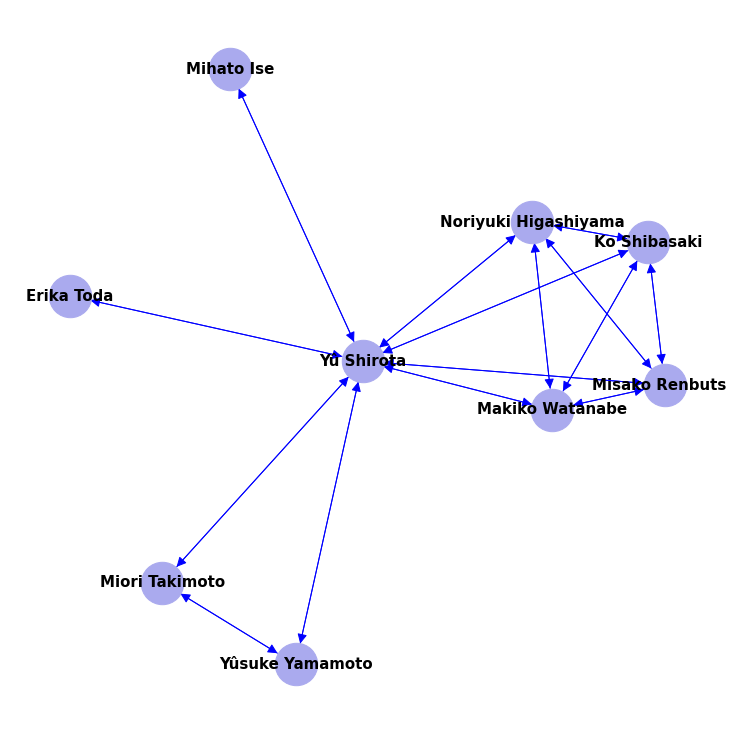

time: 1.91 s (started: 2021-07-16 13:47:42 +00:00)


In [33]:
get_subgraph(df_sample, links, 9)

# PageRank

##Functions

In [34]:
def get_genres(df_title_basics):
  """
    This function extract all possible genres from the IMDb movies dataset

    Args:
      df_title_basics : the dataset from which we want to extract the genres
    
    Returns:
      the list of possible genres of the products in the dataset
  """
  genres = []
  for el in df_title_basics["genres"]:
    genres.append(el.split(","))

  genres = list(set(flatten(genres)))
  return genres

def get_actors(df_sample):
  """
    This function extract all possible actors from the IMDb movies dataset

    Args:
      df_sample : the dataset from which we want to extract the actors
    
    Returns:
      the list of all the actors in the dataset
  """
  return  df_sample["nconst"].unique()

time: 7.84 ms (started: 2021-07-16 13:47:44 +00:00)


In [35]:
def create_dicts(df_sample, actors_enum):
  """
    This function create two dictionaries that associate each actor to the movies he/she performed in and each product with the cast that worked in it

    Args:
      df_sample : the dataset we want to extract informations from
      actors_enum : the list of all considered actors

    Returns:
      a dictionary containing for each product the cast that performed in it, dictionary containing for each actor the movies in which he/she performed and an ID to univoquely identify him/her
  """
  movies_dict = {movie : [] for movie in df_sample["tconst"].unique()}
  actors_dict = {actor : [[], i] for actor, i in zip(actors_enum, range(len(actors_enum)))}

  for i in range(len(df_sample["tconst"])) :
    movies_dict[df_sample["tconst"][i]].append(df_sample["nconst"][i])
    actors_dict[df_sample["nconst"][i]][0].append(df_sample["tconst"][i])

  return movies_dict, actors_dict

def create_genres_dict(df_sample, genres):
  """
    This function create a dictionary that associate each genre to the actors related to it

    Args:
      df_sample : the dataset we want to extract informations from
      genres : the list of all possible genres in the dataset

    Returns:
      a dictionary containing for each genre the actors related to it
  """
  genres_dict = {genre : [] for genre in genres}

  for _, row in df_sample.iterrows():
    for el in row["genres"].split(","): 
      genres_dict [el].append(row["nconst"])

  for el in genres_dict: 
    genres_dict [el] = list(set(genres_dict[el]))

  return genres_dict

def create_ratings_dict(df_sample, actors_enum, actors_dict):
  """
    This function create a dictionary that associate each actor to the average rating of the movies he/she performed in

    Args:
      df_sample : the dataset we want to extract informations from
      actors_enum : the list of all considered actors
      actors_dict : a dictionary containing for each actor the movies in which he/she performed and an ID to univoquely identify him/her

    Returns:
      a dictionary containing for each actor the average rating of the movies he/she performed in
  """
  avg_ratings = {actor : 0 for actor in actors_enum}
  
  for i in range(len(df_sample)):
    avg_ratings[df_sample["nconst"][i]] += df_sample["averageRating"][i]

  for el in avg_ratings:
    avg_ratings[el] /= 10 * len(actors_dict[el][0])

  return avg_ratings  

def get_links(actors_enum, movies_dict, actors_dict):
  """
    This function create a dictionary that associate each actor to the actors he/she performed with

    Args:
      df_sample : the dataset we want to extract informations from
      actors_enum : the list of all considered actors
      movies_dict : a dictionary containing for each product the cast that performed in it
      actors_dict : a dictionary containing for each actor the movies in which he/she performed and an ID to univoquely identify him/her

    Returns:
      a dictionary containing for each actor the actors he/she performed with
  """
  links = {actor : [] for actor in actors_enum}

  for actor in actors_enum:
    for movie in actors_dict[actor][0] :
      links[actor].append(movies_dict[movie])
    links[actor] = list(set(flatten(links[actor]))) 

  return links

time: 47.8 ms (started: 2021-07-16 13:47:44 +00:00)


In [36]:
def create_connection_matrix(links):
    """
    This function create the connection matrix

    Args:
      links : a dictionary containing for each actor the actors he/she performed with

    Returns:
      a connection matrix  whose entries are in the form (act2, act1, 1/num_outerlinks_act1)
    """
    connection_matrix = []
    for a in links:
      for b in links[a]:
        connection_matrix.append((b, a, 1./len(links[a])))
    
    return connection_matrix

time: 4.4 ms (started: 2021-07-16 13:47:44 +00:00)


In [37]:
def get_page_rank(actors_enum, links, actors_dict, logger, beta=0.8,
                  max_iterations=400, tolerance=1.e-5, verbose=False):
    """
      Page Rank algorithm
      
      Args:
        actors_enum : list of all possible actors
        links : the association between actors that worked in the same project
        actors_dict : the association between actors and projects in which they took part
        logger : the logger used to write to the correspondent log file
        beta : the parameter regulating teleporting, if equals 1 it leads to the basic version of pagerank without taxation (default = 0.8)
        max_iterations : the maximum number of iteration allowed (default = 400)
        tolerance : the minimum difference between actual and old page rank (default = 1.e-5)
        verbose : boolean, if True at each iteration print computed pagerank 

      Returns: 
        the computed page rank for each actor
    """

    connection_matrix = create_connection_matrix(links)
    rdd = sc.parallelize(connection_matrix).cache()

    n = len(actors_enum)
    page_rank = np.ones(n)/n
    old_page_rank = np.ones(n)
    
    iteration = 0
    while np.linalg.norm(old_page_rank - page_rank) and iteration < max_iterations:
        old_page_rank = page_rank
        page_rank_values = (rdd.map(lambda t: (actors_dict[t[0]][1], t[2]*page_rank[actors_dict[t[1]][1]]))
                            .reduceByKey(lambda a, b: a+b)
                            .sortByKey()
                            .collect()
                           )
        page_rank = np.array([beta*c + (1-beta)/n
                              for (i, c) in page_rank_values])
            
        if verbose:
            print(page_rank)

        iteration += 1
        
    print('{} iterations'.format(iteration))
    logger.info(f'Iterations: {iteration}')
    
    return page_rank

time: 21.2 ms (started: 2021-07-16 13:47:44 +00:00)


In [38]:
def get_topic_page_rank(actors_enum, links, actors_dict, topics, genres_dict, logger, trustrank = False, beta=0.8,
                  max_iterations=400, tolerance=1.e-5, verbose=False):
  
    """
      Topic Sensitive Page Rank algorithm

      Args:
        actors_enum : list of all possible actors
        links : the association between actors that worked in the same project
        actors_dict : the association between actors and projects in which they took part
        topics : the list of preferred topics (or the trusted pages if trustrank = True)
        genres_dict : a dictionary containing for each genre the products related to it
        logger : the logger used to write to the correspondent log file
        trustrank : if True we're computing the Trustrank variant of the algorithm
        beta : the parameter regulating teleporting, if equals 1 it leads to the basic version of pagerank without taxation (default = 0.8)
        max_iterations : the maximum number of iteration allowed (default = 400)
        tolerance : the minimum difference between actual and old page rank (default = 1.e-5)
        verbose : boolean, if True at each iteration print computed pagerank 

      Returns: 
        the computed page rank for each actor
    """

    connection_matrix = create_connection_matrix(links)
    rdd = sc.parallelize(connection_matrix).cache()

    n = len(actors_enum)
    page_rank = np.ones(n)/n
    old_page_rank = np.ones(n)

    if (not trustrank):
      s = 0
      for el in topics: 
        s += len(genres_dict[el])
    else:
      s = np.sum(topics)

    iteration = 0
    while np.linalg.norm(old_page_rank - page_rank) and iteration < max_iterations:
        old_page_rank = page_rank
        page_rank_values = (rdd.map(lambda t: (actors_dict[t[0]][1], t[2]*page_rank[actors_dict[t[1]][1]]))
                            .reduceByKey(lambda a, b: a+b)
                            .sortByKey()
                            .collect()
                           )
        page_rank = np.array([beta*c + (1-beta)/s
                              for (i, c) in page_rank_values])
            
        if verbose:
            print(page_rank)

        iteration += 1
        
    print('{} iterations'.format(iteration))
    logger.info(f'Iterations: {iteration}')
    
    return page_rank

time: 43.4 ms (started: 2021-07-16 13:47:44 +00:00)


In [39]:
def get_spam_mass(actors_enum, links, actors_dict, logger, beta=0.8,
                  max_iterations=400, tolerance=1.e-5, verbose=False):
  """
    Trust Rank algorithm
    The Trust Rank is obtained as the ratio between the number of projects in which the actor took part divided by the maximum number of projects in which an actor took part
    TrustRank is like topic-sensitive PageRank, where the “topic” is a set of nodes believed to be trustworthy (not spam)
    
    Input:
    actors_enum: list of all possible actors
    links: the association between actors that worked in the same project
    actors_dict: the association between actors and projects in which they took part
    logger : the logger used to write to the correspondent log file
    beta: the parameter regulating teleporting, if equals 1 it leads to the basic version of pagerank without taxation (default = 0.8)
    max_iterations: the maximum number of iteration allowed (default = 400)
    tolerance: the minimum difference between actual and old page rank (default = 1.e-5)
    verbose: boolean, if True at each iteration print computed pagerank 
    
    Returns:
      the computed spam mass for each actor; the spam mass is obtained as the ratio between the difference of Page Rank and Trust Rank and the Trust Rank itself
  """
    
  page_rank = get_page_rank(actors_enum, links, actors_dict, logger, beta, max_iterations, tolerance, verbose)

  mean = np.mean(np.array([len(actors_dict[actor][0]) for actor in actors_enum]))

  trust_topics = np.array([1 if len(actors_dict[actor][0]) >= mean else 0 for actor in actors_enum])
  trust_rank = get_topic_page_rank(actors_enum, links, actors_dict, trust_topics, _, logger, trustrank=True, max_iterations=max_iterations) 

  spam_mass = (page_rank - trust_rank)/trust_rank

  return spam_mass

time: 13.3 ms (started: 2021-07-16 13:47:44 +00:00)


In [40]:
def get_spam_mass_ratings(actors_enum, links, actors_dict, avg_ratings, logger, beta=0.8,
                  max_iterations=400, tolerance=1.e-5, verbose=False):
  '''
    Trust Rank algorithm
    The Trust Rank is obtained as the the average rating given to the products in which an actor took part
    
    Args:
      actors_enum : list of all possible actors
      links : the association between actors that worked in the same project
      actors_dict : the association between actors and projects in which they took part
      avg_ratings : the association between actors and their average rating on projects in which they have taken part
      logger : the logger used to write to the correspondent log file
      beta : the parameter regulating teleporting, if equals 1 it leads to the basic version of pagerank without taxation (default = 0.8)
      max_iterations : the maximum number of iteration allowed (default = 400)
      tolerance : the minimum difference between actual and old page rank (default = 1.e-5)
      verbose : boolean, if True at each iteration print computed pagerank 
    
    Returns: 
      the computed spam mass for each actor; the spam mass is obtained as the ratio between the difference of Page Rank and Trust Rank and the Trust Rank itself
  '''
    
  page_rank = get_page_rank(actors_enum, links, actors_dict, logger, beta, max_iterations, tolerance, verbose)

  mean = np.mean(np.array([avg_ratings[actor] for actor in avg_ratings]))
  trust_topics = np.array([1 if avg_ratings[actor] >= mean else 0 for actor in avg_ratings])

  trust_rank = get_topic_page_rank(actors_enum, links, actors_dict, trust_topics, _, logger, trustrank= True, max_iterations=max_iterations) 

  spam_mass = (page_rank - trust_rank)/trust_rank

  return spam_mass

time: 16.9 ms (started: 2021-07-16 13:47:44 +00:00)


In [41]:
def setup_logger(name, log_file, level=logging.INFO):
    '''
      To setup as many loggers as you want
      Args:
      name : name of the logger
      log_file : name of the correspondent log fileprint computed pagerank 
      level = level of the log (info, warning, ...)

    Returns: 
      the created logger
    '''    

    formatter = logging.Formatter('%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')
    handler = logging.FileHandler(log_file)        
    handler.setFormatter(formatter)

    logger = logging.getLogger(name)
    logger.setLevel(level)
    logger.addHandler(handler)

    return logger

time: 8.29 ms (started: 2021-07-16 13:47:44 +00:00)


## Basic implementation

*n* is the number of times you want to repeat the experiment

In [42]:
n = 5

logger_pagerank = setup_logger('experiments_pagerank', 'experiments_pagerank.log')
for iter in range(n):
  logger_pagerank.info('This experiment implements PageRank')

  s_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]
  time_basic = np.zeros(len(s_rates))

  for i in range(len(s_rates)):
    df_sample = preprocess_dataset(df_title_basics_copy, df_principals_copy, df_name_basics_copy, df_ratings_copy, sampling_rate = s_rates[i])
    actors_enum = get_actors(df_sample)
  
    movies_dict, actors_dict = create_dicts(df_sample, actors_enum)
    links = get_links(actors_enum, movies_dict, actors_dict)

    tic = time.time()
    get_page_rank(actors_enum, links, actors_dict, logger_pagerank, beta=1, max_iterations = 150)
    toc = time.time()
    time_basic[i] = toc-tic
    logger_pagerank.info(f'Sampling: {s_rates[i]}, Time: {time_basic[i]}')
    print(time_basic[i]) 

Sample size: 34
1 iterations
3.544386625289917
Sample size: 340
1 iterations
0.5794167518615723
Sample size: 3404
1 iterations
0.8892350196838379
Sample size: 34044
120 iterations
202.59213423728943
Sample size: 340443
150 iterations
1453.2743821144104
time: 32min 58s (started: 2021-07-16 13:47:44 +00:00)


In [43]:
files.download('experiments_pagerank.log')
file = open('experiments_pagerank.log', 'r')
experiments_pagerank = file.read().splitlines()
file.close()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 11.2 ms (started: 2021-07-16 14:20:42 +00:00)


## Pagerank with taxation

In [44]:
n = 1

logger_taxation = setup_logger('experiments_taxation', 'experiments_taxation.log')
for iter in range(n):
  logger_taxation.info('This experiment implements PageRank with taxation')

  s_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]
  time_taxation =  np.zeros(len(s_rates))

  for i in range(len(s_rates)):
    df_sample = preprocess_dataset(df_title_basics_copy, df_principals_copy, df_name_basics_copy, df_ratings_copy, sampling_rate = s_rates[i])
    actors_enum = get_actors(df_sample)
  
    movies_dict, actors_dict = create_dicts(df_sample, actors_enum)
    links = get_links(actors_enum, movies_dict, actors_dict)

    tic = time.time()
    get_page_rank(actors_enum, links, actors_dict, logger_taxation, max_iterations = 150)
    toc = time.time()
    time_taxation[i] = toc-tic
    logger_taxation.info(f'Sampling: {s_rates[i]}, Time: {time_taxation[i]}')
    print(time_taxation[i]) 

Sample size: 34
1 iterations
0.2586073875427246
Sample size: 340
1 iterations
0.3037548065185547
Sample size: 3404
1 iterations
0.43696165084838867
Sample size: 34044
24 iterations
38.032129764556885
Sample size: 340443
150 iterations
1427.7856419086456
time: 29min 34s (started: 2021-07-16 14:26:39 +00:00)


In [45]:
files.download('experiments_taxation.log')
file = open('experiments_taxation.log', 'r')
experiments_taxation = file.read().splitlines()
file.close()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 15.1 ms (started: 2021-07-16 14:56:14 +00:00)


## Topic-sensitive pagerank

In [46]:
n = 5

logger_topic_pagerank = setup_logger('experiments_topic_pagerank', 'experiments_topic_pagerank.log')

for iter in range(n):
  logger_topic_pagerank.info('This experiment implements Topic-Sensitive PageRank')

  s_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]
  time_topic = np.zeros(len(s_rates))

  for i in range(len(s_rates)):
    df_sample = preprocess_dataset(df_title_basics_copy, df_principals_copy, df_name_basics_copy, df_ratings_copy, sampling_rate = s_rates[i])
    actors_enum = get_actors(df_sample)
    genres = get_genres(df_title_basics_copy)
  
    movies_dict, actors_dict = create_dicts(df_sample, actors_enum)
    genres_dict = create_genres_dict(df_sample, genres)
    links = get_links(actors_enum, movies_dict, actors_dict)

    tic = time.time()
    get_topic_page_rank(actors_enum, links, actors_dict, ['Western', 'Fantasy', 'Horror'], genres_dict, logger_topic_pagerank, max_iterations = 150)
    toc = time.time()
    time_topic[i] = toc-tic
    logger_topic_pagerank.info(f'Sampling: {s_rates[i]}, Time: {time_topic[i]}')
    print(time_topic[i]) 

Sample size: 34
150 iterations
41.778738021850586
Sample size: 340
150 iterations
36.48508310317993
Sample size: 3404
150 iterations
58.38608455657959
Sample size: 34044
150 iterations
228.97546768188477
Sample size: 340443
150 iterations
1421.1763916015625
time: 37min 9s (started: 2021-07-16 14:56:14 +00:00)


In [47]:
files.download('experiments_topic_pagerank.log')
file = open('experiments_topic_pagerank.log', 'r')
experiments_topic_pagerank = file.read().splitlines()
file.close()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 15.2 ms (started: 2021-07-16 15:33:23 +00:00)


##Trust-rank variant 

In [48]:
n = 5

logger_trust_rank = setup_logger('experiments_trust_rank', 'experiments_trust_rank.log')

for iter in range(n):
  logger_trust_rank.info('This experiment implements TrustRank variant with numbers of movies')

  s_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]
  time_trust =  np.zeros(len(s_rates))

  for i in range(len(s_rates)):
    df_sample = preprocess_dataset(df_title_basics_copy, df_principals_copy, df_name_basics_copy, df_ratings_copy, sampling_rate = s_rates[i])
    actors_enum = get_actors(df_sample)
  
    movies_dict, actors_dict = create_dicts(df_sample, actors_enum)
    links = get_links(actors_enum, movies_dict, actors_dict)

    tic = time.time()
    get_spam_mass(actors_enum, links, actors_dict, logger_trust_rank, max_iterations = 150)
    toc = time.time()
    time_trust[i] = toc-tic
    logger_trust_rank.info(f'Sampling: {s_rates[i]}, Time: {time_trust[i]}')
    print(time_trust[i])

Sample size: 34
1 iterations
1 iterations
0.5374817848205566
Sample size: 340
1 iterations
1 iterations
0.4767024517059326
Sample size: 3404
2 iterations
150 iterations
61.05098295211792
Sample size: 34044
19 iterations
150 iterations
272.870867729187
Sample size: 340443
150 iterations
150 iterations
2897.5121533870697
time: 58min 40s (started: 2021-07-16 15:33:23 +00:00)


In [49]:
files.download('experiments_trust_rank.log')
file = open('experiments_trust_rank.log', 'r')
experiments_trust_rank = file.read().splitlines()
file.close()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 11.6 ms (started: 2021-07-16 16:32:04 +00:00)


In [50]:
n = 5

logger_trust_rank_2 = setup_logger('experiments_trust_rank_2', 'experiments_trust_rank_2'.log')

for iter in range(n):
  logger_trust_rank_2.info('This experiment implements TrustRank variant with ratings')

  s_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]
  time_trust =  np.zeros(len(s_rates))

  for i in range(len(s_rates)):
    df_sample = preprocess_dataset(df_title_basics_copy, df_principals_copy, df_name_basics_copy, df_ratings_copy, sampling_rate = s_rates[i])
    actors_enum = get_actors(df_sample)
  
    movies_dict, actors_dict = create_dicts(df_sample, actors_enum)
    avg_ratings = create_ratings_dict(df_sample, actors_enum, actors_dict)
    links = get_links(actors_enum, movies_dict, actors_dict)

    tic = time.time()
    get_spam_mass_ratings(actors_enum, links, actors_dict, avg_ratings, logger_trust_rank_2, max_iterations = 150)
    toc = time.time()
    time_trust[i] = toc-tic
    logger_trust_rank_2.info(f'Sampling: {s_rates[i]}, Time: {time_trust[i]}')
    print(time_trust[i])

Sample size: 34
1 iterations
150 iterations
33.35688352584839
Sample size: 340
1 iterations
150 iterations
35.787102699279785
Sample size: 3404
1 iterations
150 iterations
60.60299468040466
Sample size: 34044
67 iterations
150 iterations
348.9218249320984
Sample size: 340443
150 iterations
150 iterations
2905.7422235012054
time: 1h 1min 30s (started: 2021-07-16 16:32:04 +00:00)


In [53]:
files.download('experiments_trust_rank_2.log')
file = open('experiments_trust_rank_2.log', 'r')
experiments_trust_rank_2 = file.read().splitlines()
file.close()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 13.1 ms (started: 2021-07-16 17:55:33 +00:00)


# Results 

In [72]:
files = ['experiments_pagerank.log', 'experiments_taxation.log', 'experiments_topic_pagerank.log',
         'experiments_trust_rank.log', 'experiments_trust_rank_2.log']
M = []

for f in files: 
  file = open(f, 'r')
  lines = file.read().splitlines()
  file.close()
  
  x = []

  for i in lines: 
    pos = i.find("Time: ")
    if pos != -1: 
      x.append(float(i[pos + len("Time: "):]))
  M.append(x)

mean = [[0 for x in range(n)] for y in range(len(files))] 

for i in range(len(files)):
  for j in range(len(M[i])):  
    mean[i][j%n] += M[i][j]

mean = np.array(mean)
print(mean)
for i in range(len(files)): 
  mean[i] = mean [i] / n 

print(f'Time mean: \n {mean}')  

[[5.87679362e+00 1.72592854e+00 2.71197486e+00 6.90478453e+02
  7.36327846e+03]
 [4.15929413e+00 1.62421370e+00 2.21398211e+00 2.64899388e+02
  6.81985996e+03]
 [2.19534711e+02 1.96238854e+02 3.00257056e+02 1.17651176e+03
  7.38011095e+03]
 [1.06206720e+01 1.64101323e+02 3.21964872e+02 1.58148103e+03
  1.49443037e+04]
 [1.95041986e+02 1.84438994e+02 3.02105934e+02 1.47593964e+03
  1.52714151e+04]]
Time mean: 
 [[1.17535872e+00 3.45185709e-01 5.42394972e-01 1.38095691e+02
  1.47265569e+03]
 [8.31858826e-01 3.24842739e-01 4.42796421e-01 5.29798777e+01
  1.36397199e+03]
 [4.39069422e+01 3.92477707e+01 6.00514112e+01 2.35302352e+02
  1.47602219e+03]
 [2.12413440e+00 3.28202645e+01 6.43929744e+01 3.16296207e+02
  2.98886073e+03]
 [3.90083972e+01 3.68877988e+01 6.04211869e+01 2.95187928e+02
  3.05428301e+03]]
time: 25.5 ms (started: 2021-07-16 18:04:52 +00:00)


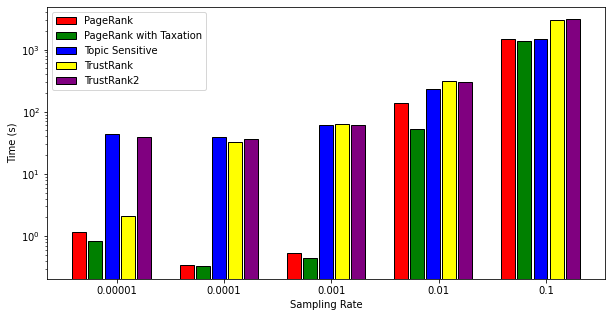

time: 686 ms (started: 2021-07-16 18:04:59 +00:00)


In [73]:
plt.figure(figsize=[10, 5])
s_rate = ['0.00001', '0.0001', '0.001', '0.01', '0.1']

X = np.arange(len(s_rate))
plt.bar(X, mean[0], color = 'r', edgecolor = 'black', width = 0.13)
plt.bar(X + 0.15, mean[1], color = 'g', edgecolor = 'black', width = 0.13)
plt.bar(X + 2 * 0.15, mean[2], color = 'b', edgecolor = 'black', width = 0.13)
plt.bar(X + 3 * 0.15, mean[3], color = 'yellow',edgecolor = 'black', width = 0.13)
plt.bar(X + 4 * 0.15, mean[4], color = 'purple', edgecolor = 'black', width = 0.13)

plt.xticks([i + 0.35 for i in range(n)], s_rate)
plt.yscale('log')

plt.ylabel('Time (s)')
plt.xlabel('Sampling Rate')

plt.legend(['PageRank', 'PageRank with Taxation','Topic Sensitive', 'TrustRank', 'TrustRank2'])
plt.savefig('time_algorithms.png')
plt.show()

In [74]:
files = ['experiments_pagerank.log', 'experiments_taxation.log', 'experiments_topic_pagerank.log']
M = []

for f in files: 
  file = open(f, 'r')
  lines = file.read().splitlines()
  file.close()
  
  x = []

  for i in lines: 
    pos = i.find("Iterations: ")
    if pos != -1: 
      x.append(float(i[pos + len("Iterations: "):]))
  M.append(x)

mean = [[0 for x in range(n)] for y in range(len(files))] 

for i in range(len(files)):
  for j in range(len(M[i])):  
    mean[i][j%n] += M[i][j]
    

mean = np.array(mean)

for i in range(len(files)):
  mean[i] = mean [i] / n 

print(f'Mean iterations: \n {mean}')


Mean iterations: 
 [[  1.    1.    1.   86.2 150. ]
 [  1.    1.    1.   35.4 150. ]
 [150.  150.  150.  150.  150. ]]
time: 18.5 ms (started: 2021-07-16 18:05:03 +00:00)


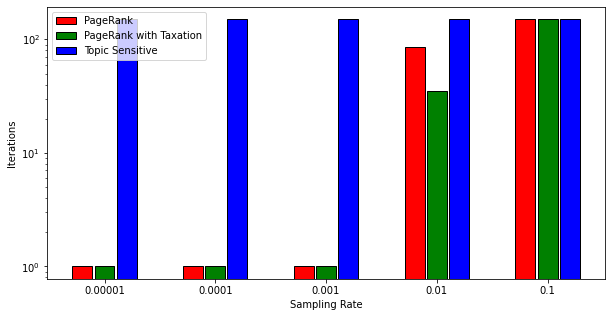

time: 572 ms (started: 2021-07-16 18:03:35 +00:00)


In [68]:
plt.figure(figsize=[10, 5])
s_rate = ['0.00001', '0.0001', '0.001', '0.01', '0.1']

X = np.arange(len(s_rate))
plt.bar(X, mean[0], color = 'r', edgecolor = 'black', width = 0.18)
plt.bar(X + 0.20, mean[1], color = 'g', edgecolor = 'black', width = 0.18)
plt.bar(X + 2 * 0.20, mean[2], color = 'b', edgecolor = 'black', width = 0.18)

plt.xticks([i + 0.20 for i in range(n)], s_rate)
plt.yscale('log')

plt.ylabel('Iterations')
plt.xlabel('Sampling Rate')

plt.legend(['PageRank', 'PageRank with Taxation','Topic Sensitive'])
plt.savefig('iter_algorithms3.png')
plt.show()

In [75]:
file = open('experiments_trust_rank.log', 'r')
lines = file.read().splitlines()
file.close()
  
x = []
for i in lines: 
  pos = i.find("Iterations: ")
  if pos != -1: 
    x.append(float(i[pos + len("Iterations: "):]))

mean_pr = np.zeros(n)
mean_topic = np.zeros(n)

j = 0
k = 0

for i in range(len(x)):
  if i%2 == 0:   
    mean_pr[j%n] += x[i]
    j+=1
    
  else: 
    mean_topic[k%n] += x[i] 
    k +=1

mean_pr /= n
mean_topic /= n
print(f'Mean iterations 1st-TrustRank using PageRank: {mean_pr}')
print(f'Mean iterations 1st-TrustRank using Topic Sensitive: {mean_topic}')


Mean iterations 1st-TrustRank using PageRank: [  1.    1.    1.   43.8 150. ]
Mean iterations 1st-TrustRank using Topic Sensitive: [  1.  120.2 150.  150.  150. ]
time: 15.4 ms (started: 2021-07-16 18:05:11 +00:00)


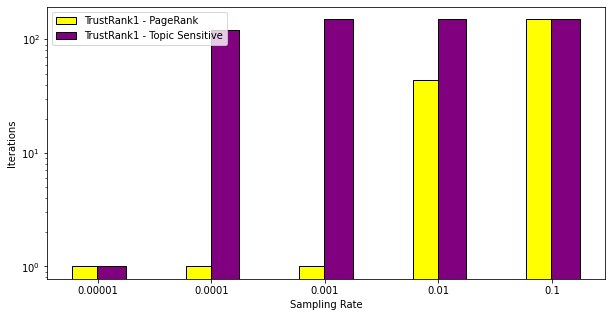

time: 527 ms (started: 2021-07-16 18:05:15 +00:00)


In [76]:
plt.figure(figsize=[10, 5])
s_rate = ['0.00001', '0.0001', '0.001', '0.01', '0.1']

X = np.arange(len(s_rate))
plt.bar(X, mean_pr, color = 'yellow', edgecolor = 'black', width = 0.25)
plt.bar(X + 0.22, mean_topic, color = 'purple', edgecolor = 'black', width = 0.25)

plt.xticks([i + 0.10 for i in range(n)], s_rate)
plt.yscale('log')

plt.ylabel('Iterations')
plt.xlabel('Sampling Rate')

plt.legend(['TrustRank1 - PageRank', 'TrustRank1 - Topic Sensitive'])
plt.savefig('iter_algorithms_tr1.png')
plt.show()

In [77]:
file = open('experiments_trust_rank_2.log', 'r')
lines = file.read().splitlines()
file.close()
  
x = []

for i in lines: 
  pos = i.find("Iterations: ")
  if pos != -1: 
    x.append(float(i[pos + len("Iterations: "):]))

mean_pr = np.zeros(n)
mean_topic = np.zeros(n)

j = 0
k = 0

for i in range(len(x)):
  if i%2 == 0:   
    mean_pr[j%n] += x[i]
    j+=1
    
  else: 
    mean_topic[k%n] += x[i] 
    k +=1

mean_pr /= n
mean_topic /= n
print(f'Mean iterations 2nd-TrustRank using PageRank: {mean_pr}')
print(f'Mean iterations 2dn-TrustRank using Topic Sensitive: {mean_topic}')

Mean iterations 2nd-TrustRank using PageRank: [  1.    1.    1.   36.8 150. ]
Mean iterations 2dn-TrustRank using Topic Sensitive: [150. 150. 150. 150. 150.]
time: 18.6 ms (started: 2021-07-16 18:05:43 +00:00)


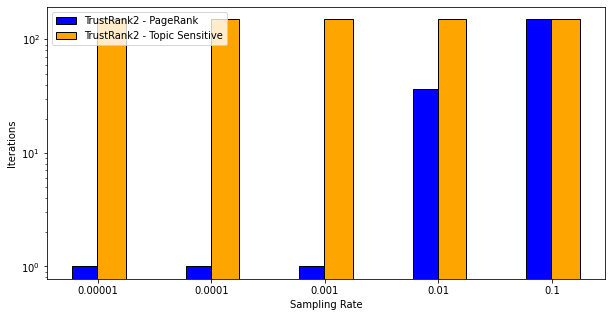

time: 536 ms (started: 2021-07-16 18:05:46 +00:00)


In [78]:
plt.figure(figsize=[10, 5])
s_rate = ['0.00001', '0.0001', '0.001', '0.01', '0.1']

X = np.arange(len(s_rate))
plt.bar(X, mean_pr, color = 'b', edgecolor = 'black', width = 0.25)
plt.bar(X + 0.22, mean_topic, color = 'orange', edgecolor = 'black', width = 0.25)

plt.xticks([i + 0.10 for i in range(n)], s_rate)
plt.yscale('log')

plt.ylabel('Iterations')
plt.xlabel('Sampling Rate')

plt.legend(['TrustRank2 - PageRank', 'TrustRank2 - Topic Sensitive'])
plt.savefig('iter_algorithms_tr2.png')
plt.show()